In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms
import os
import torch.nn.functional as F

import config
from model import SRGAN_GEN, SRGAN_DISC
from loss import PerceptualLoss, DiscriminatorLoss
from utils import psnr_srgan, ssim_srgan
from data import UcsrTrainValidDataset
import matplotlib.pyplot as plt

## UCSR 데이터셋 확인

In [2]:
from PIL import Image
from torchvision import transforms
data_path1 = '/home/lab/Datasets/UCSR_Datasets/Train/LR_x4/0001.png'
image1 = Image.open(data_path1).convert("RGB")

In [35]:
image1_tensor = transforms.ToTensor()(image1)
print(image1_tensor.shape)

torch.Size([3, 351, 510])


In [36]:
data_path2 = '/home/lab/Datasets/UCSR_Datasets/Train/LR_HIFI/high/0001_HIFI_high.png'
image2 = Image.open(data_path2).convert("RGB")

In [37]:
image2_tensor = transforms.ToTensor()(image2)
print(image2_tensor.shape)

torch.Size([3, 351, 510])


In [40]:
psnr_srgan(image1_tensor, image2_tensor)

np.float64(26.75395000174732)

## 훈련 데이터 잘 뜨나 확인

In [3]:
train_config = config.train_config

In [4]:
train_config['train_data_path']

'/home/lab/Datasets/UCSR_Datasets/Train/LR_HIFI/high'

In [5]:
train_valid = UcsrTrainValidDataset(train_config['train_data_path'])
train_data = train_valid.get_train()
valid_data = train_valid.get_valid()

train_loader = DataLoader(train_data, batch_size=train_config['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=train_config['batch_size'],  shuffle=False)

train length: 2760, valid length:690


In [6]:
input, target = train_data[14]
print(input.shape, target.shape)

torch.Size([3, 24, 24]) torch.Size([3, 96, 96])


In [7]:
input, target = train_data[14]

upscaled_input = F.interpolate(input.unsqueeze(0), scale_factor=4, mode='bicubic', align_corners=False).squeeze(0)
upscaled_input = torch.clamp(upscaled_input, 0, 1)
psnr_srgan( upscaled_input, target)

np.float64(20.64975291752028)

In [22]:
torch.max(upscaled_input)

tensor(0.9619)

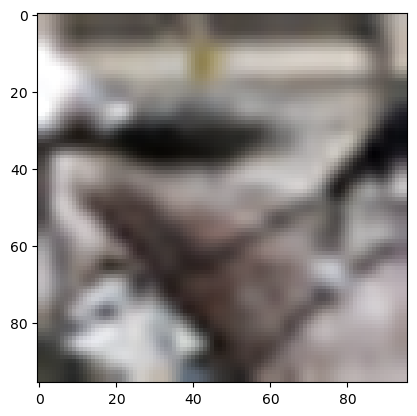

In [8]:
plt.imshow(upscaled_input.permute(1, 2, 0).numpy())

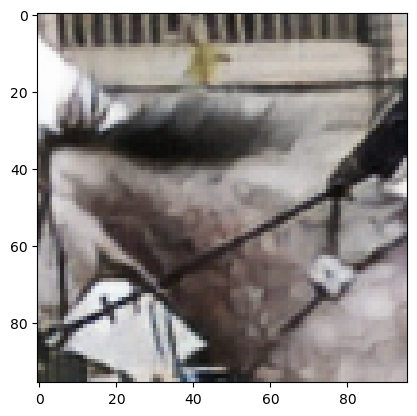

In [9]:
plt.imshow(target.permute(1, 2, 0).numpy())

In [10]:
input, target = train_data[15]

***(torch.Size([3, 24, 24]), torch.Size([3, 96, 96]))


In [11]:
input, target = valid_data[0]

***(torch.Size([3, 24, 24]), torch.Size([3, 96, 96]))


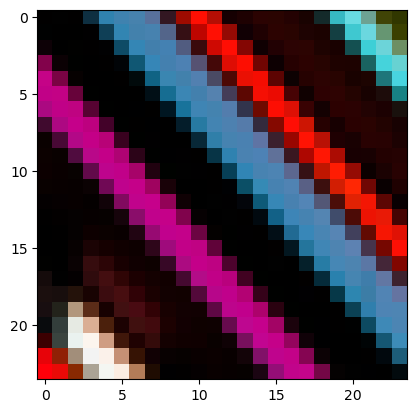

In [12]:
plt.imshow(input.permute(1, 2, 0).numpy())

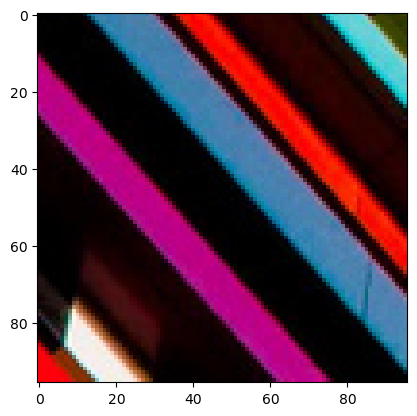

In [13]:
plt.imshow(target.permute(1, 2, 0).numpy())

## 기타 확인

In [ ]:
print(len(input))

In [ ]:
generator = SRGAN_GEN().to(train_config['device'])
n = 0

for input_train, target_train in train_loader:
    if n == 1:
        break
    n += 1
    input_train = input_train.to(train_config['device'])
    temp_target = target_train[0]
    target_train = target_train.to(train_config['device'])
    generated_image = generator(input_train).to(train_config['device'])
    temp_generated = generated_image[0]
    print(f'PSNR: {psnr_srgan(generated_image, target_train)}')

In [ ]:
print(temp_generated.shape, temp_target.shape)
print(psnr_srgan(temp_generated, temp_target))

In [ ]:
temp_generated = torch.concat([temp_generated.unsqueeze(0), temp_generated.unsqueeze(0)], dim=0)
temp_target = torch.concat([temp_target.unsqueeze(0), temp_target.unsqueeze(0)], dim=0)
print(temp_generated.shape, temp_target.shape)
print(psnr_srgan(temp_generated, temp_target))
# 결론: psnr_srgan은 배치 2개(=총 개수)에 대한 평균 PSNR을 구해준다

In [ ]:
plt.imshow(temp_generated.detach().cpu().permute(1, 2, 0).numpy())

In [ ]:
plt.imshow(temp_target.detach().cpu().permute(1, 2, 0).numpy())

In [ ]:
train_test = UcsrTrainValidDataset(train_config['train_lr_path'], train_config['train_hr_path'])
train_data = train_test.get_train()
valid_data = train_test.get_valid()

train_loader = DataLoader(train_data, batch_size=train_config['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=train_config['batch_size'],  shuffle=False)

# 모델 및 옵티마이저, 손실함수
generator = SRGAN_GEN().to(train_config['device'])
discriminator = SRGAN_DISC().to(train_config['device'])
optimizer_gen = optim.Adam(generator.parameters(), lr=train_config['learning_rate'])
optimizer_disc = optim.Adam(discriminator.parameters(), lr=train_config['learning_rate'])
criterion_gen = PerceptualLoss().to(train_config['device'])
criterion_disc = DiscriminatorLoss().to(train_config['device'])

for epoch in range(1, train_config['num_epochs']):
    #### train ####
    avg_train_loss_gen = 0
    avg_train_loss_disc = 0
    avg_train_psnr = 0
    avg_train_ssim = 0
    epoch_train_loss_gen = 0
    epoch_train_loss_disc = 0
    epoch_train_psnr = 0
    epoch_train_ssim = 0
    num_of_images = 0
    
    for input_train, target_train in tqdm(train_loader):
        print(f'input_train shape: {input_train.shape}, target_train type: {target_train.shape}')
        generator.train()
        discriminator.train()
        input_train = input_train.to(train_config['device'])
        target_train = target_train.to(train_config['device'])
        num_of_images += input_train.shape[0]
        
        # generator 업데이트    
        generated_image = generator(input_train).to(train_config['device'])
        discriminated_output = discriminator(generated_image)
    
        optimizer_gen.zero_grad()
        loss_gen = criterion_gen(generated_image, discriminated_output, target_train)
        loss_gen.backward()
        optimizer_gen.step()
        
        # generator loss, psnr, ssim 축적
        epoch_train_loss_gen += loss_gen.item()
        temp_psnr = psnr_srgan(generated_image, target_train)
        print(f'batch PSNR: {temp_psnr}')
        epoch_train_psnr += temp_psnr
        epoch_train_ssim += ssim_srgan(generated_image, target_train)
        
        # discriminator 업데이트
        generated_image = generator(input_train)
        discriminated_fake = discriminator(generated_image.detach())
        discriminated_real = discriminator(target_train)
        
        optimizer_disc.zero_grad()
        loss_disc = criterion_disc(discriminated_fake, discriminated_real)
        loss_disc.backward()
        optimizer_disc.step()
        
        # discriminator loss 축적
        epoch_train_loss_disc += loss_disc.item()

    print(f'Total PSNR per batch: {epoch_train_psnr}')
    avg_train_loss_gen = epoch_train_loss_gen / len(train_loader.dataset)
    avg_train_loss_disc = epoch_train_loss_disc / len(train_loader.dataset)
    avg_train_psnr = epoch_train_psnr / num_of_images
    avg_train_ssim = epoch_train_ssim / num_of_images
    print(f'Epoch {epoch} / Generator Loss: {avg_train_loss_gen}, Discriminator Loss: {avg_train_loss_disc},\
        PSNR: {avg_train_psnr}, SSIM: {avg_train_ssim}')
        
    #### eval ####
    avg_val_psnr_gen = 0
    avg_val_ssim_gen = 0
    epoch_val_psnr_gen = 0
    epoch_val_ssim_gen = 0
    generator.eval()
    for input_val, target_val in tqdm(valid_loader):
        print(f'input_valid shape: {input_val.shape}, target_valid type: {target_val.shape}')
        input_val = input_val.to(train_config['device'])
        target_val = target_val.to(train_config['device'])
        
        generated_image = generator(input_val).to(train_config['device'])
        epoch_val_psnr_gen += psnr_srgan(generated_image, target_val)
        epoch_val_ssim_gen += ssim_srgan(generated_image, target_val)
    
    avg_val_psnr_gen = epoch_val_psnr_gen / len(valid_loader.dataset)
    avg_val_ssim_gen = epoch_val_ssim_gen / len(valid_loader.dataset)
    print(f'Validation PSNR: {avg_val_psnr_gen}, SSIM: {avg_val_ssim_gen}')
    
    if (epoch % train_config['saving_epoch_period'] == 0):
        torch.save(generator.state_dict(), os.path.join(train_config['model_save_path'], f'gen_epoch{epoch}'))
        torch.save(discriminator.state_dict(), os.path.join(train_config['model_save_path'], f'disc_epoch{epoch}'))